# HW3 图像分类

## 导包

In [1]:
!pip install torchviz

In [3]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 27.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


In [2]:
import numpy as np
import pandas as pd
import torch
import math
import os
import random
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchviz import make_dot
# ConcateDataset & Subset 会在半监督学习的数据用到
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

from tqdm.auto import tqdm
from tqdm import tqdm

# 绘制评估曲线
from torch.utils.tensorboard import SummaryWriter

e:\ProgramFiles\Anaconda3\envs\LEEDL\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 一些重要函数

In [ ]:
def model_plot(model_class, input_sample):
    clf = model_class()
    y = clf(input_sample)
    clf_view = make_dot(y, params=dict(list(clf.named_parameters()) + [("x", input_sample)]))
    return clf_view

# 设置全局的随机种子
def all_seed(seed = 6666):
    """
    设置随机种子
    """
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed) 
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed) 
    # python 全局
    os.environ['PYTHONHASHSEED'] = str(seed) 
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')

def quick_observe(train_dir_root):
    """ 
    快速观察训练集中的9张照片
    """
    pics_path = [os.path.join(train_dir_root, i) for i in os.listdir(train_dir_root)]
    labels = [i.split("_")[0] for i in os.listdir(train_dir_root)]
    idxs = np.arange(len(labels))
    sample_idx = np.random.choice(idxs, size=9, replace=False)
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    for idx_, i in enumerate(sample_idx):
        row = idx_ // 3
        col = idx_ % 3
        img = Image.open(pics_path[i])
        axes[row, col].imshow(img)
        c = labels[i]
        axes[row, col].set_title(f"class_{c}")

    plt.show()

## 数据准备（数据转换、数据增广）

In [ ]:
train_dir_root = "./food11/training"
quick_observe(train_dir_root)

## &#x2728; Transforms

上图的图像大小不一致，最小的图片处理也需要将图片切成一样大小

In [ ]:
# 最基础的，将图片裁剪成相同大小，并转换成Tensor就行
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


# 训练集可以做一些数据增广
train_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    # 这部分可以加一些图片处理操作
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    # ToTensor() 放在所有处理的最后
    transforms.ToTensor(),
])

## 数据集

数据的标签在文件名中，可以在加载数据时，将文件名处理成标签

In [16]:
from email.mime import image


class FoodDataset(Dataset):

    def __init__(self, path, tfm=test_tfm, files=None):
        super(FoodDataset).__init__()
        self.path = path
        self.tfm = tfm
        self.files = sorted([os.path.join(path, x) for x in os.listdir(path) if x.endswith("jpg")])
        if files!= None:
            self.files = files
        print(f"One {path} Sample:", self.files[0])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_path = self.files[idx]
        img = Image.open(image_path)
        img = self.tfm(img)
        try:
            label = int(image_path.split("/")[-1].split("_")[0])
        except:
            # test dataset 没有label
            label = -1
        return img, label


## &#x2728; 神经网络模型

In [ ]:
from torchvision.models import resnet50

# resNet = resnet50(pretrained=True)

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input 维度 (3, 128, 128）
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), # (64, 128, 128)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # (64, 64, 64)

            nn.Conv2d(64, 128, 3, 1, 1), # (128, 64, 64)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # (128, 32, 32)

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )

        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )
        
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

/opt/miniconda3/envs/LEEDL/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/LEEDL/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


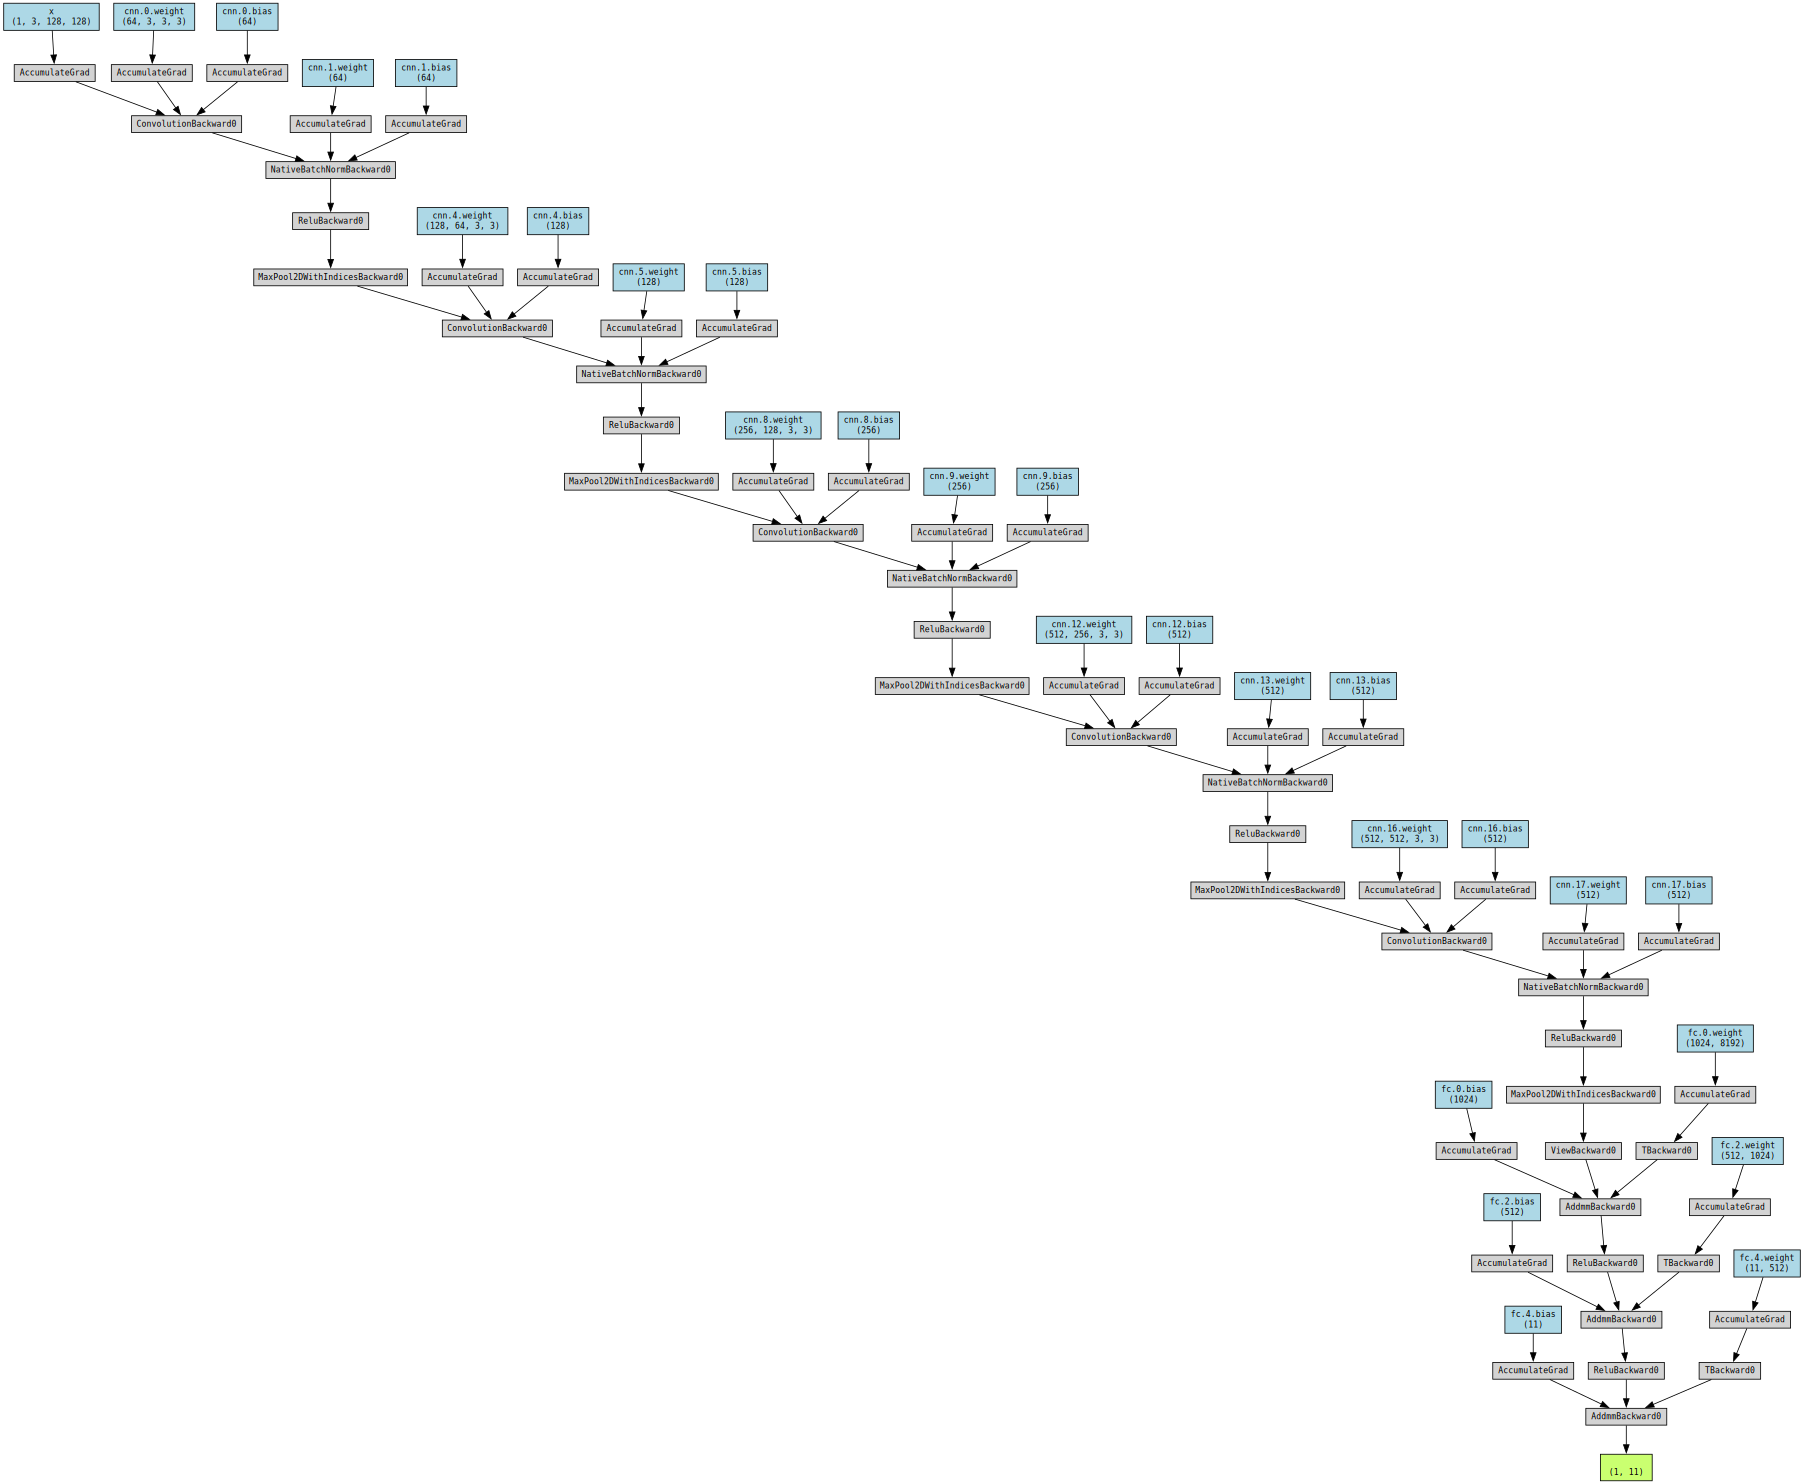

In [11]:
x = torch.randn(1, 3, 128, 128).requires_grad_(True)
model_plot(Classifier, x)

## &#x2728; 训练部分

In [38]:
def trainer(train_loader, valid_loader, model, config, device, rest_net_flag=False):

    # 对于分类任务通常使用 cross-entropy 评估模型效果
    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    # 初始化优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    # 模型存储位置
    save_path = config["resnet_save_path"] if rest_net_flag else config["save_path"]

    writer = SummaryWriter()
    if not os.path.isdir("./models"):
        os.mkdir("./models")
    
    n_epochs, best_loss, step, early_stop_count = config["n_epochs"], math.inf, 0, 0
    for epoch in range(n_epochs):
        model.train()
        loss_record = []
        train_accs = []
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x) # (batch_size, class_num) 👉 (512, 11)
            loss = criterion(pred, y)
            loss.backward()
            # 使用 nn.utils.clip_grad_norm_() 避免梯度爆炸
            if config["clip_flag"]:
                grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            optimizer.step()
            step += 1
            acc = (pred.argmax(dim=-1) == y.to(device)).float().mean() # 把bool类型转化为float，计算mean相当于计算准确率
            l_ = loss.detach().item()
            loss_record.append(l_)
            train_accs.append(acc.detach().item())
            train_pbar.set_description(f"Epoch [{epoch+1}/{n_epochs}]")
            train_pbar.set_postfix({"loss" : f"{l_:.5f}", "acc" : f"{acc:.5f}"})
            
        mean_train_acc = sum(train_accs) / len(train_accs)
        mean_train_loss = sum(loss_record) / len(loss_record)
        writer.add_scalar("Loss/train", mean_train_loss, step)
        writer.add_scalar("Acc/train", mean_train_acc, step)
        
        model.eval()
        loss_record = []
        acc_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)
                acc = (pred.argmax(dim=-1) == y).float().mean()
            
            loss_record.append(loss.item())
            acc_record.append(acc.item())
        
        mean_valid_acc = sum(acc_record) / len(acc_record)
        mean_valid_loss = sum(loss_record) / len(loss_record)
        print(f"Epoch [{epoch + 1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Train acc: {mean_train_acc}; Valid loss: {mean_valid_loss:.4f}, Valid acc: {mean_valid_acc:.4f}")   
        writer.add_scalar("Loss/valid", mean_valid_loss, step)
        writer.add_scalar("Acc/valid", mean_valid_acc, step)
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), save_path)
            print("Saving model with loss {:.3f}...".format(best_loss))
            early_stop_count = 0
        else:
            early_stop_count += 1
        
        if early_stop_count >= config["early_stop"]:
            print("\nModel is not improving, so we halt the training session.")
            return



## 超参数设置

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
config = {
    "seed" : 6666,
    "dataset_dir" : "./food11",
    "n_epochs" : 1,
    "batch_size" : 64,
    "learning_rate" : 0.0003,
    "weight_decay" : 1e-5,
    "early_stop" : 300,
    "clip_flag" : True,
    "save_path" : "./models/model.ckpt",
    "resnet_save_path" : "./models/resnet_model.ckpt"
}

print(device)
all_seed(config["seed"])

cpu
Set env random_seed = 6666


## 导入数据

1. FoodDataset：用文件路径，transform方法构建数据集
2. DataLoader：使用pytorch的DataLoader类，将数据集进行批量处理，并返回一个迭代器【按batch加载数据】

In [55]:
import test


_dataset_dir = config["dataset_dir"]

train_set = FoodDataset(os.path.join(_dataset_dir, "training"), tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)

valid_set = FoodDataset(os.path.join(_dataset_dir, "validation"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)

# test集保证输出顺序一致，不需要shuffle
test_set = FoodDataset(os.path.join(_dataset_dir, "test"), tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=config["batch_size"], shuffle=False, num_workers=0, pin_memory=True)

One ./food11/training Sample: ./food11/training/0_0.jpg
One ./food11/validation Sample: ./food11/validation/0_0.jpg
One ./food11/test Sample: ./food11/test/0001.jpg


## 测试集数据增广

In [56]:
test_set = FoodDataset(os.path.join(_dataset_dir, "test"), tfm=test_tfm)
test_loader_extra1 = DataLoader(test_set, batch_size=config["batch_size"], shuffle=False, num_workers=0, pin_memory=True)

test_set = FoodDataset(os.path.join(_dataset_dir, "test"), tfm=test_tfm)
test_loader_extra2 = DataLoader(test_set, batch_size=config["batch_size"], shuffle=False, num_workers=0, pin_memory=True)

test_set = FoodDataset(os.path.join(_dataset_dir, "test"), tfm=test_tfm)
test_loader_extra3 = DataLoader(test_set, batch_size=config["batch_size"], shuffle=False, num_workers=0, pin_memory=True)

One ./food11/test Sample: ./food11/test/0001.jpg
One ./food11/test Sample: ./food11/test/0001.jpg
One ./food11/test Sample: ./food11/test/0001.jpg


## 开始训练

In [34]:
model = Classifier().to(device)
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/1]: 100%|██████████| 155/155 [03:32<00:00,  1.37s/it, loss=1.89162, acc=0.40000]


AttributeError: 'list' object has no attribute 'mean'

啊啊啊！！！刚买的mac跑模型燃起来了，好心疼啊，跑出来还报错了。。。
还是用windows主力机跑模型吧，心疼ing。。。
注意计算acc，不要用 list.mean() 
```python
acc = acc_list.mean() ❌
```

老老实实用
```python
acc = sum(acc_list) / len(acc_list)
```
或者转换为np数组再计算
```python
acc = np.array(acc_list).mean()
```
或者
```python
acc = torch.tensor(acc_list).float().mean()  # 正确，输出 tensor(3.)
```

In [37]:
# 用windows跑报错了，还是用mac吧。。。
# batch_size改成4，心里好多了，再加上小风扇呼呼吹上
model = Classifier().to(device)
trainer(train_loader, valid_loader, model, config, device)

  0%|          | 0/155 [00:00<?, ?it/s]/opt/miniconda3/envs/LEEDL/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch [1/1]: 100%|██████████| 155/155 [03:31<00:00,  1.37s/it, loss=1.89162, acc=0.40000]


Epoch [1/1]: Train loss: 2.1581, Train acc: 0.2421975806836159; Valid loss: 1.9693, Valid acc: 0.3154
Saving model with loss 1.969...


## 测试并生成预测结果的csv

In [44]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(config["save_path"]))
model_best.eval()
prediction = []
with torch.no_grad():
    for data, _ in tqdm(test_loader):
        data = data.to(device)
        test_pred = model_best(data)
        # print(test_pred.shape)
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()




100%|██████████| 53/53 [00:29<00:00,  1.80it/s]


In [45]:
print(prediction)

[9, 9, 5, 9, 1, 2, 9, 9, 5, 9, 9, 4, 9, 9, 4, 9, 9, 10, 9, 9, 9, 10, 10, 5, 0, 9, 10, 2, 9, 9, 2, 2, 9, 5, 3, 9, 5, 9, 9, 9, 9, 4, 5, 5, 9, 9, 2, 9, 5, 5, 5, 4, 9, 10, 9, 9, 2, 9, 9, 9, 5, 9, 2, 5, 5, 2, 3, 2, 4, 9, 9, 9, 2, 9, 9, 4, 9, 9, 6, 9, 9, 9, 10, 5, 2, 5, 3, 2, 9, 5, 5, 9, 9, 9, 2, 9, 3, 1, 5, 5, 9, 5, 9, 9, 9, 5, 9, 9, 5, 2, 5, 10, 3, 3, 3, 9, 9, 0, 9, 2, 9, 5, 9, 9, 1, 9, 2, 5, 10, 9, 5, 3, 9, 9, 2, 5, 9, 9, 9, 9, 2, 5, 5, 9, 0, 9, 9, 9, 2, 5, 5, 5, 5, 9, 4, 5, 9, 5, 9, 2, 5, 5, 5, 9, 5, 2, 10, 5, 5, 9, 9, 2, 9, 3, 3, 9, 0, 5, 5, 2, 1, 5, 10, 5, 9, 5, 9, 9, 5, 2, 5, 5, 2, 9, 2, 10, 2, 3, 9, 9, 9, 3, 5, 9, 10, 9, 9, 5, 9, 5, 0, 5, 9, 9, 5, 5, 5, 0, 9, 5, 0, 9, 9, 2, 4, 9, 9, 9, 5, 4, 5, 9, 5, 2, 9, 6, 10, 9, 9, 2, 5, 5, 10, 9, 3, 10, 5, 10, 9, 4, 5, 5, 3, 9, 9, 9, 9, 3, 9, 5, 9, 9, 4, 10, 6, 2, 3, 9, 5, 9, 5, 0, 5, 9, 9, 5, 10, 3, 5, 5, 5, 9, 9, 5, 3, 2, 3, 10, 9, 9, 3, 1, 9, 0, 3, 5, 9, 2, 3, 4, 4, 5, 9, 10, 2, 9, 4, 2, 9, 4, 5, 4, 2, 2, 10, 10, 3, 9, 9, 10, 9, 0, 5, 9, 9, 9

## soft vote（软投票）预测

使用增广测试集进行四次预测，然后使用soft vote进行预测。

In [57]:
test_loaders = [test_loader_extra1, test_loader_extra2, test_loader_extra3, test_loader]
loader_nums = len(test_loaders)
# 存储每个dataloader的预测结果，一个dataloader的一个数组
loader_pred_list = []
for idx, d_loader in enumerate(test_loaders):
    # 存储一个dataloader的预测结果，一个batch是一个数组
    pred_arr_list = []
    with torch.no_grad():
        tq_bar = tqdm(d_loader)
        tq_bar.set_description(f"[ DataLoader {idx+1} / {loader_nums} ]")
        for data, _ in tq_bar:
            test_pred = model_best(data.to(device))
            logit_pred = test_pred.cpu().data.numpy()
            pred_arr_list.append(logit_pred)
            # print("0: ", logit_pred.shape) # (64, 11)
            # print("1: ", len(pred_arr_list)) # 1 👉 2 👉 3 ...
            # print("shape: ", np.concatenate(pred_arr_list, axis=0).shape) # (concat_batch_size, 11)

        # 将每个batch的预测结果合并成一个数组
        loader_pred_list.append(np.concatenate(pred_arr_list, axis=0)) # append([batch_size, 11])
        
#合并预测结果
pred_arr = np.zeros(loader_pred_list[0].shape)
for pred_arr_t in loader_pred_list:
    pred_arr += pred_arr_t

soft_vote_prediction = np.argmax(0.5 * pred_arr / len(loader_pred_list) + 0.5 * pred_arr_list[-1], axis=1)

[ DataLoader 4 / 4 ]: 100%|██████████| 53/53 [00:28<00:00,  1.86it/s]


ValueError: operands could not be broadcast together with shapes (3347,11) (19,11) 

很奇怪，分步骤计算就不会报错

In [64]:
print("Sanity checks before voting:")
print("Number of loaders:", len(loader_pred_list))
print("pred_arr shape:", pred_arr.shape)
print("last prediction shape:", loader_pred_list[-1].shape)
print("0.5 * pred_arr / len shape:", (0.5 * pred_arr / len(loader_pred_list)).shape)
print("0.5 * last_pred shape:", (0.5 * loader_pred_list[-1]).shape)

# 分步计算以调试
avg_component = 0.5 * pred_arr / len(loader_pred_list)
last_component = 0.5 * loader_pred_list[-1]
print("avg_component shape:", avg_component.shape)
print("last_component shape:", last_component.shape)

# 尝试手动执行加法
combined = avg_component + last_component  # 这行可能会抛出错误
soft_vote_prediction = np.argmax(combined, axis=1)

Sanity checks before voting:
Number of loaders: 4
pred_arr shape: (3347, 11)
last prediction shape: (3347, 11)
0.5 * pred_arr / len shape: (3347, 11)
0.5 * last_pred shape: (3347, 11)
avg_component shape: (3347, 11)
last_component shape: (3347, 11)


In [65]:
df = pd.DataFrame()
# 保证ID为四位数（前面填充0）
df['ID'] = [str(i).zfill(4) for i in range(1, 1 + len(test_set))]
df["Category"] = soft_vote_prediction
df.to_csv("submission.csv", index=False)

## 残差网络（Residual Net）

resNet同理，只是把model改成resNet即可。
心疼电脑，不再赘述。